# SSNE - Mini projekt 2
## Przewidywanie kategorii cenowej mieszkań
### Wojtek Zarzecki, Janek Filipecki

Załóżmy, że chcemy kupić mieszkanie. Do dyspozycji mamy 100 000 dolarów, możemy też wziąć kredyt na kolejne 250 tysięcy, co da nam w sumie budżet w wysokości 350 000 dolarów. Stwórzmy model który pomoże nam przewidzieć, czy mieszkanie o pewnych, zadanych parametrach, możemy kupić za własne pieniądze (cheap), z kredytem (average), czy jest poza naszym zasięgiem (expensive).

W oparciu o dostępne atrybuty zbuduj model, który pomoże oszacować, czy dana nieruchomość należy do klasy cheap, average czy expensive. Do dyspozycji mają Państwo dane treningowe (train_data.csv) z oryginalnymi cenami nieruchomości (SalePrice), oraz, tak jak ostatnio, zbiór testowy (test_data.csv).

UWAGA Proszę dokładnie zastosować się do poniższej instrukcji
W ramach rozwiązania, proszę oddać poprzez Teamsy plik - archiwum .zip z kodem (w formie notebooka, lub skryptu/skryptów .py) oraz plikiem .csv z predykcjami na zbiorze test_data.csv.
W pliku z predykcjami powinna się znajdować dokładnie jedna kolumna, oznaczająca przewidywaną przez Państwa klasę ceny mieszkania (0 <- cheap, 1 <- average, 2 <- expensive).
Końcowe wyniki obliczał będę w oparciu o średnią dokładność dla każdej klasy. Proszę zwrócić uwagę na fakt, że klasy są mocno niezbalansowane!
Koniecznie proszę sprawdzić format zwracanych przez Państwa predykcji (tyle predykcji ile elementów w zbiorze testowym, brak nagłówków, jedna kolumna, itd.)
Bardzo proszę nazywać wszystkie pliki nazwiskami autorów (najlepiej alfabetycznie), lub nazwą zespołu. Nazwę głównego archiwum zip proszę dodatkowo rozpocząć od przedrostka poniedzialek_ lub piatek_ (nie pon/pia), proszę też nie umieszczać plików w dodatkowych podfolderach tylko bezpośrednio .
W MS ​Teams wszystkim przydzieliłem zadanie, ale bardzo proszę, żeby tylko jeden (dowolny) członek zespołu je zwrócił.
W razie pytań zapraszam do korespondencji lub na konsultacje.

In [62]:
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import numpy as np
import pandas as pd
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [63]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [64]:
train_data = pd.read_csv("pakiet/train_data.csv")
target_task_data = pd.read_csv("pakiet/test_data.csv")

### Wstępna analiza danych

In [65]:
train_data.describe()

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
count,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000
mean,222177.477207,2002.977934,959.958778,11.994665,192.789040,572.857662,6.313773,11.055771,5.824200,9.860330,10.872696
std,106325.535526,8.765838,384.548456,7.581330,215.455916,408.179957,3.224556,7.717030,2.344331,3.444848,4.427445
min,34070.000000,1978.000000,135.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,144752.000000,1993.000000,644.000000,6.000000,11.000000,184.000000,5.000000,5.000000,4.000000,8.000000,7.000000
50%,209588.000000,2006.000000,910.000000,11.000000,100.000000,536.000000,6.000000,11.000000,5.000000,9.000000,10.000000
75%,291570.000000,2007.000000,1160.000000,17.000000,249.000000,798.000000,8.000000,16.000000,7.000000,13.000000,15.000000
max,585840.000000,2015.000000,2337.000000,43.000000,713.000000,1321.000000,14.000000,27.000000,10.000000,16.000000,17.000000


In [66]:
for c in train_data.columns:
    print("---- %s ---" % c)
    print(train_data[c].value_counts())

---- SalePrice ---
149274    38
75920     38
176991    38
265486    36
230088    35
          ..
227876     1
194247     1
328318     1
76106      1
557522     1
Name: SalePrice, Length: 841, dtype: int64
---- YearBuilt ---
2007    881
2005    512
1993    478
2006    471
1992    322
2013    307
2014    271
1986    244
2008    198
2009    164
2015     89
1997     77
1978     51
1985     47
2003      8
1980      4
Name: YearBuilt, dtype: int64
---- Size(sqf) ---
914    683
644    491
910    381
868    209
572    198
      ... 
715      1
291      1
163      1
277      1
839      1
Name: Size(sqf), Length: 89, dtype: int64
---- Floor ---
4     228
7     225
13    214
11    213
8     211
5     210
6     204
10    190
15    189
12    188
3     184
9     179
2     174
14    171
16    148
17    139
1     138
18    132
19    129
20    119
21     96
24     75
22     64
23     52
25     49
26     42
27     22
29     20
30     19
31     18
28     16
33     14
43      7
32      7
41      7
35     

Sprawdźmy współczynniki korelacji pomiędzy kolumnami a wartością przewidywaną

/tmp/ipykernel_6229/3391318548.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  features.corr()
/tmp/ipykernel_6229/3391318548.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(features.corr(), annot=True, fmt=".2f", cmap="coolwarm")


<AxesSubplot:>

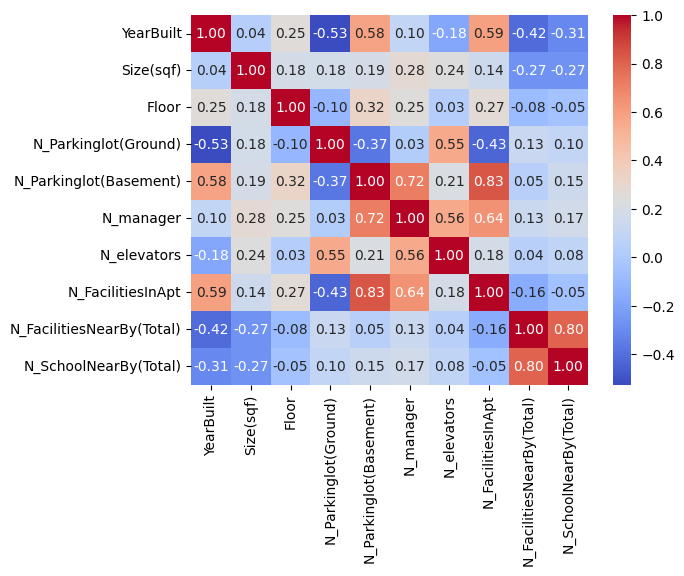

In [67]:
features = train_data.drop("SalePrice", axis=1)
features.corr()
sns.heatmap(features.corr(), annot=True, fmt=".2f", cmap="coolwarm")

Z powyższej analizy wynika że potencjalnie możemy pozbyć się kolumn "HeatingType", "SubwayStation"

In [68]:
sale_prices = train_data["SalePrice"]
expensive = sale_prices[sale_prices > 350000].count()
print("expensive: %s" % expensive)
average = sale_prices[sale_prices > 100000].count() - expensive
print("average: %s" % average)
cheap = len(sale_prices) - average - expensive
print("cheap: %s" % cheap)

expensive: 570
average: 2992
cheap: 562


Jak widać dataset jest istotnie dość niezbalansowany

In [69]:
train_data.dtypes

SalePrice                      int64
YearBuilt                      int64
Size(sqf)                      int64
Floor                          int64
HallwayType                   object
HeatingType                   object
AptManageType                 object
N_Parkinglot(Ground)         float64
N_Parkinglot(Basement)       float64
TimeToBusStop                 object
TimeToSubway                  object
N_manager                    float64
N_elevators                  float64
SubwayStation                 object
N_FacilitiesInApt              int64
N_FacilitiesNearBy(Total)    float64
N_SchoolNearBy(Total)        float64
dtype: object

### Encoding

In [70]:
price_category = pd.cut(train_data["SalePrice"], bins = [0, 100000, 350000, np.inf], labels=["cheap", "average", "expensive"])
train_data.insert(0, "PriceCategory", price_category)
train_data.dtypes

PriceCategory                category
SalePrice                       int64
YearBuilt                       int64
Size(sqf)                       int64
Floor                           int64
HallwayType                    object
HeatingType                    object
AptManageType                  object
N_Parkinglot(Ground)          float64
N_Parkinglot(Basement)        float64
TimeToBusStop                  object
TimeToSubway                   object
N_manager                     float64
N_elevators                   float64
SubwayStation                  object
N_FacilitiesInApt               int64
N_FacilitiesNearBy(Total)     float64
N_SchoolNearBy(Total)         float64
dtype: object

In [71]:
def one_hot_encoder(df):
    columns = df.select_dtypes(include=[object, 'category']).columns
    output_df = df.copy()
    for c in columns:
        output_df = output_df.drop(c, axis=1).join(pd.get_dummies(train_data[c], c))
    return output_df

In [72]:
# Usuwam kolumny "HeatingType", "SubwayStation"
encoded_train = one_hot_encoder(train_data.drop(["HeatingType", "SubwayStation"], axis=1))
encoded_target_task_data = one_hot_encoder(target_task_data.drop(["HeatingType", "SubwayStation"], axis=1))
encoded_train

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),...,AptManageType_management_in_trust,AptManageType_self_management,TimeToBusStop_0~5min,TimeToBusStop_10min~15min,TimeToBusStop_5min~10min,TimeToSubway_0-5min,TimeToSubway_10min~15min,TimeToSubway_15min~20min,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby
0,141592,2006,814,3,111.0,184.0,3.0,0.0,5,6.0,...,1,0,0,0,1,0,1,0,0,0
1,51327,1985,587,8,80.0,76.0,2.0,2.0,3,12.0,...,0,1,1,0,0,0,0,0,1,0
2,48672,1985,587,6,80.0,76.0,2.0,2.0,3,12.0,...,0,1,1,0,0,0,0,0,1,0
3,380530,2006,2056,8,249.0,536.0,5.0,11.0,5,3.0,...,1,0,1,0,0,1,0,0,0,0
4,78318,1992,644,2,142.0,79.0,4.0,8.0,3,9.0,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,570796,2007,1928,24,0.0,1270.0,14.0,16.0,10,9.0,...,1,0,1,0,0,1,0,0,0,0
4120,307079,2015,644,22,102.0,400.0,5.0,10.0,7,7.0,...,1,0,1,0,0,0,0,0,1,0
4121,357522,2007,868,20,0.0,1270.0,14.0,16.0,10,9.0,...,1,0,1,0,0,1,0,0,0,0
4122,312389,1978,1327,1,87.0,0.0,1.0,4.0,3,7.0,...,0,1,1,0,0,1,0,0,0,0


### Skalowanie

In [73]:
scaler = MinMaxScaler()
encoded_train.iloc[:, 1:] = scaler.fit_transform(encoded_train.iloc[:, 1:])

/tmp/ipykernel_6229/1946651109.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  encoded_train.iloc[:, 1:] = scaler.fit_transform(encoded_train.iloc[:, 1:])


### Dataset do regresji i klasyfikacji

In [74]:
encoded_train_classification = encoded_train.drop(columns=['SalePrice'], axis=1)
encoded_train_regression = encoded_train.drop(columns=['PriceCategory_cheap', 'PriceCategory_average','PriceCategory_expensive'], axis=1)

### Train test split

In [75]:
clean_train_classification_data, clean_test_classification_data = train_test_split(encoded_train_classification, test_size=0.2, random_state=42)

### Data loadery

In [76]:
class RealEstateDatasetClassification(Dataset):
    def __init__(self, data):
        self.X = torch.tensor(data.drop(columns=['PriceCategory_cheap', 'PriceCategory_average','PriceCategory_expensive'], axis=1).values, dtype=torch.float32)
        self.y = torch.tensor(data[['PriceCategory_cheap', 'PriceCategory_average','PriceCategory_expensive']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [82]:
train_dataloader_classification = DataLoader(RealEstateDatasetClassification(clean_train_classification_data), batch_size=124, shuffle=True)
test_dataloader_classification = DataLoader(RealEstateDatasetClassification(clean_test_classification_data), batch_size=124, shuffle=True)

### Definicja modelu

In [83]:
class RealEstateClassifier(nn.Module):
    def __init__(self):
        super(RealEstateClassifier, self).__init__()
        self.fc1 = nn.Linear(23, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 3)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [91]:
def train(model, train_loader=train_dataloader_classification, test_loader=test_dataloader_classification, learning_rate=0.001, epoch_num=5):

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=0.01)
    results = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': [], 'train_avg_class_acc': [], 'valid_avg_class_acc': []}

    model.to(device)

    for epoch in range(epoch_num):
        # train
        loss_sum, acc_sum, correct_class_0_sum, correct_class_1_sum, correct_class_2_sum, count_0, count_1, count_2, count = 0, 0, 0, 0, 0, 0, 0, 0, 0
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(features)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_sum += loss

            _, predicted = torch.max(outputs, 1)
            _, target = torch.max(labels, 1)
            acc_sum += (predicted == target).sum()

            correct_class_0_sum += ((predicted == target)*(target == 0)).sum()
            correct_class_1_sum += ((predicted == target)*(target == 1)).sum()
            correct_class_2_sum += ((predicted == target)*(target == 2)).sum()
            count_0 += (target == 0).sum()
            count_1 += (target == 1).sum()
            count_2 += (target == 2).sum()

            count += len(features)

        epoch_train_loss = loss_sum/count
        epoch_train_acc = acc_sum/count
        epoch_train_class_avg_acc = (correct_class_0_sum / count_0 + correct_class_1_sum / count_1 + correct_class_2_sum / count_2)/3

        # validate
        loss_sum, acc_sum, correct_class_0_sum, correct_class_1_sum, correct_class_2_sum, count_0, count_1, count_2, count = 0, 0, 0, 0, 0, 0, 0, 0, 0
        with torch.no_grad():
            model.eval()
            for features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)
                
                outputs = model(features)
                loss = loss_function(outputs, labels)
                loss_sum += loss

                _, predicted = torch.max(outputs, 1)
                _, target = torch.max(labels, 1)
                acc_sum += (predicted == target).sum()
                
                correct_class_0_sum += ((predicted == target)*(target == 0)).sum()
                correct_class_1_sum += ((predicted == target)*(target == 1)).sum()
                correct_class_2_sum += ((predicted == target)*(target == 2)).sum()
                count_0 += (target == 0).sum()
                count_1 += (target == 1).sum()
                count_2 += (target == 2).sum()

                count += len(features)

        epoch_test_loss = loss_sum/count
        epoch_test_acc = acc_sum/count
        epoch_test_class_avg_acc = (correct_class_0_sum / count_0 + correct_class_1_sum / count_1 + correct_class_2_sum / count_2)/3

        if epoch % 10 == 0:
            print(f"epoch= {epoch}, TRAIN: loss= {epoch_train_loss:.4f}, acc= {epoch_train_acc:.4f}, class_avg_acc= {epoch_train_class_avg_acc:.4f}, "\
               f"TEST: loss= {epoch_test_loss:.4f}, acc= {epoch_test_acc:.4f}, class_avg_acc= {epoch_test_class_avg_acc:.4f}")

        results['train_loss'].append(epoch_train_loss)
        results['train_acc'].append(epoch_train_acc)
        results['valid_loss'].append(epoch_test_loss)
        results['valid_acc'].append(epoch_test_acc)
        results['train_avg_class_acc'].append(epoch_train_class_avg_acc)
        results['valid_avg_class_acc'].append(epoch_test_class_avg_acc)

    # move results to cpu
    return {k: [v.cpu().detach().numpy() for v in values] for k, values in results.items()}

In [94]:
model = RealEstateClassifier()
results = train(model, epoch_num=100)

epoch= 0, TRAIN: loss= 0.0056, acc= 0.7366, class_avg_acc= 0.6292, TEST: loss= 0.0054, acc= 0.7830, class_avg_acc= 0.5350
epoch= 10, TRAIN: loss= 0.0027, acc= 0.8493, class_avg_acc= 0.7705, TEST: loss= 0.0027, acc= 0.8533, class_avg_acc= 0.7881
epoch= 20, TRAIN: loss= 0.0026, acc= 0.8584, class_avg_acc= 0.7784, TEST: loss= 0.0026, acc= 0.8618, class_avg_acc= 0.8121
epoch= 30, TRAIN: loss= 0.0026, acc= 0.8563, class_avg_acc= 0.7781, TEST: loss= 0.0026, acc= 0.8667, class_avg_acc= 0.8046
epoch= 40, TRAIN: loss= 0.0026, acc= 0.8539, class_avg_acc= 0.7799, TEST: loss= 0.0026, acc= 0.8703, class_avg_acc= 0.7977
epoch= 50, TRAIN: loss= 0.0025, acc= 0.8563, class_avg_acc= 0.7757, TEST: loss= 0.0026, acc= 0.8606, class_avg_acc= 0.7972
epoch= 60, TRAIN: loss= 0.0026, acc= 0.8539, class_avg_acc= 0.7732, TEST: loss= 0.0026, acc= 0.8630, class_avg_acc= 0.8083
epoch= 70, TRAIN: loss= 0.0025, acc= 0.8551, class_avg_acc= 0.7770, TEST: loss= 0.0027, acc= 0.8424, class_avg_acc= 0.7623
epoch= 80, TRAIN:

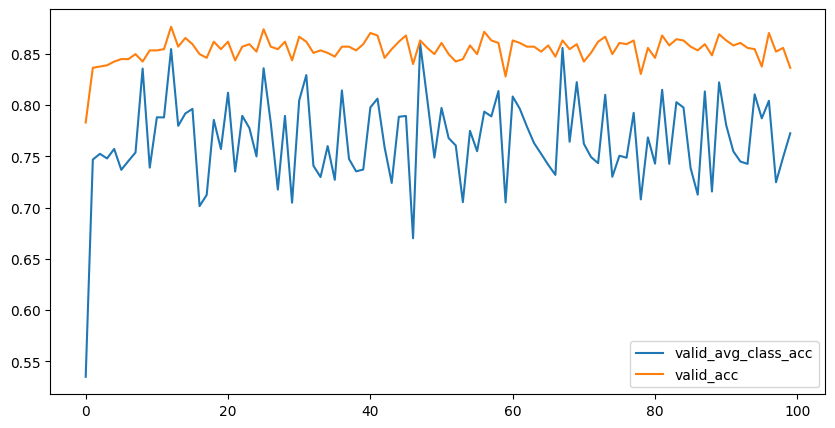

In [96]:
# plot avg class acc and acc
plt.figure(figsize=(10, 5))
# plt.plot(results['train_avg_class_acc'], label='train_avg_class_acc')
plt.plot(results['valid_avg_class_acc'], label='valid_avg_class_acc')
# plt.plot(results['train_acc'], label='train_acc')
plt.plot(results['valid_acc'], label='valid_acc')
plt.legend()

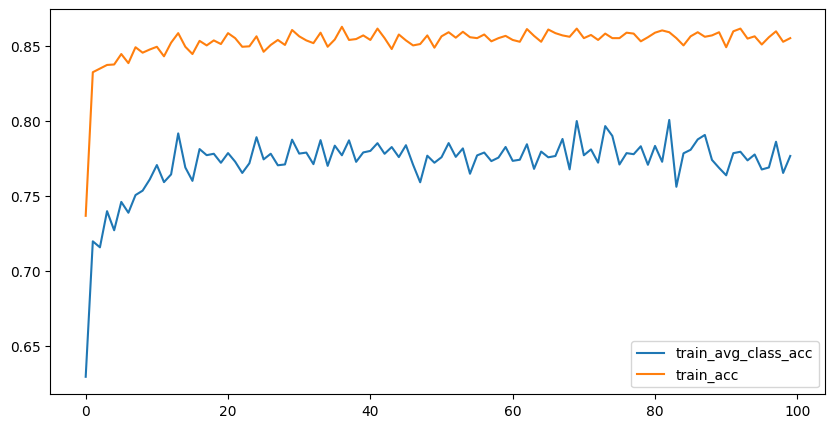

In [97]:
plt.figure(figsize=(10, 5))
plt.plot(results['train_avg_class_acc'], label='train_avg_class_acc')
# plt.plot(results['valid_avg_class_acc'], label='valid_avg_class_acc')
plt.plot(results['train_acc'], label='train_acc')
# plt.plot(results['valid_acc'], label='valid_acc')
plt.legend()

In [86]:
model.cpu()
features, labels = next(iter(test_dataloader_classification))
outputs = model(features)

_, predicted = torch.max(outputs, 1)
_, target = torch.max(labels, 1)
result = pd.DataFrame({"predicted": predicted.numpy(), "target":target.numpy()})
result[result["predicted"] == result["target"]].count() / len(result)

predicted    0.887097
target       0.887097
dtype: float64